In [4]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from triangle import triangulate, plot as tplot, convex_hull, show_data, get_data

In [5]:
t = np.linspace(0, 2 * np.pi, 100, endpoint=False)
points = np.stack((np.cos(t), np.sin(t))).T

In [6]:
seg = np.array(
    [[j, j + 1] for j in range(points.shape[0] - 1)] + [[points.shape[0] - 1, 0]]
)

# Mesh 

In [7]:
cndt = triangulate({"vertices": points, "segments": seg}, opts="Rpq1a0.003ne")

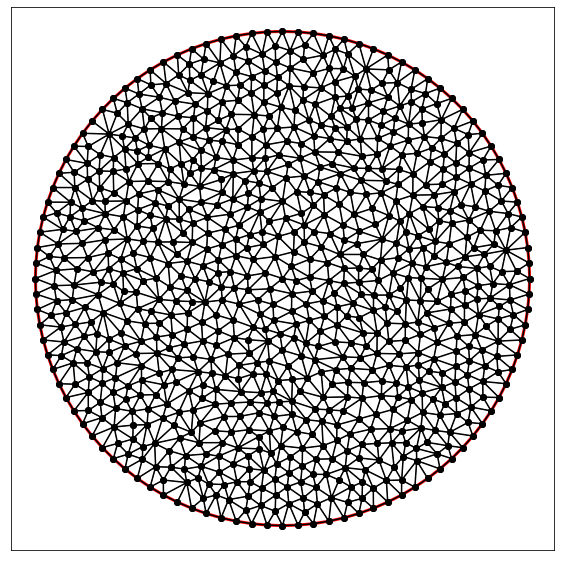

In [8]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(111, aspect="equal")
tplot(ax, **cndt)
plt.show()

In [9]:
points = cndt["vertices"]
triangles = cndt["triangles"]
neighbours = cndt["neighbors"]
triangles_s = points[triangles]
triangles_c = triangles_s.reshape(-1, 2)
vertice_maker_is_boundary = cndt["vertex_markers"]

In [10]:
matrix = np.zeros((points.shape[0], points.shape[0]), dtype=np.float64)
b = np.zeros(points.shape[0])
f = 1/(points[:, 0]**2 +points[:, 1]**2)
# f = c

for idx, element in enumerate(triangles):
    x1, x2, x3 = points[element[0], 0], points[element[1], 0], points[element[2], 0]
    y1, y2, y3 = points[element[0], 1], points[element[1], 1], points[element[2], 1]

    delta = x1 * y2 - x1 * y3 - x2 * y1 + x2 * y3 + x3 * y1 - x3 * y2

    if vertice_maker_is_boundary[element[0]] == True:
        matrix[element[0], element[0]] = 1
        b[element[0]] = 0
    else:
        matrix[element[0], element[0]] += (
            2
            * (points[element[1], 1] - points[element[2], 1])
            * (points[element[1], 1] - points[element[2], 1])
            / delta
        )
        matrix[element[0], element[1]] += (
            2
            * (points[element[1], 1] - points[element[2], 1])
            * (points[element[2], 1] - points[element[0], 1])
            / delta
        )
        matrix[element[0], element[2]] += (
            2
            * (points[element[1], 1] - points[element[2], 1])
            * (points[element[0], 1] - points[element[1], 1])
            / delta
        )

        matrix[element[0], element[0]] += (
            2
            * (points[element[1], 0] - points[element[2], 0])
            * (points[element[1], 0] - points[element[2], 0])
            / delta
        )
        matrix[element[0], element[1]] += (
            2
            * (points[element[1], 0] - points[element[2], 0])
            * (points[element[2], 0] - points[element[0], 0])
            / delta
        )
        matrix[element[0], element[2]] += (
            2
            * (points[element[1], 0] - points[element[2], 0])
            * (points[element[0], 0] - points[element[1], 0])
            / delta
        )

        b[element[0]] -= 2 * delta / 3 * f[element[0]]

    if vertice_maker_is_boundary[element[1]] == True:
        matrix[element[1], element[1]] = 1
        b[element[1]] *= 0
    else:
        matrix[element[1], element[0]] += (
            2
            * (points[element[2], 1] - points[element[0], 1])
            * (points[element[1], 1] - points[element[2], 1])
            / delta
        )
        matrix[element[1], element[1]] += (
            2
            * (points[element[2], 1] - points[element[0], 1])
            * (points[element[2], 1] - points[element[0], 1])
            / delta
        )
        matrix[element[1], element[2]] += (
            2
            * (points[element[2], 1] - points[element[0], 1])
            * (points[element[0], 1] - points[element[1], 1])
            / delta
        )

        matrix[element[1], element[0]] += (
            2
            * (points[element[2], 0] - points[element[0], 0])
            * (points[element[1], 0] - points[element[2], 0])
            / delta
        )
        matrix[element[1], element[1]] += (
            2
            * (points[element[2], 0] - points[element[0], 0])
            * (points[element[2], 0] - points[element[0], 0])
            / delta
        )
        matrix[element[1], element[2]] += (
            2
            * (points[element[2], 0] - points[element[0], 0])
            * (points[element[0], 0] - points[element[1], 0])
            / delta
        )

        b[element[1]] -= 2 * delta / 3 * f[element[0]]

    if vertice_maker_is_boundary[element[2]] == True:
        matrix[element[2], element[2]] = 1
        b[element[2]] *= 0
    else:
        matrix[element[2], element[0]] += (
            2
            * (points[element[0], 1] - points[element[1], 1])
            * (points[element[1], 1] - points[element[2], 1])
            / delta
        )
        matrix[element[2], element[1]] += (
            2
            * (points[element[0], 1] - points[element[1], 1])
            * (points[element[2], 1] - points[element[0], 1])
            / delta
        )
        matrix[element[2], element[2]] += (
            2
            * (points[element[0], 1] - points[element[1], 1])
            * (points[element[0], 1] - points[element[1], 1])
            / delta
        )

        matrix[element[2], element[0]] += (
            2
            * (points[element[0], 0] - points[element[1], 0])
            * (points[element[1], 0] - points[element[2], 0])
            / delta
        )
        matrix[element[2], element[1]] += (
            2
            * (points[element[0], 0] - points[element[1], 0])
            * (points[element[2], 0] - points[element[0], 0])
            / delta
        )
        matrix[element[2], element[2]] += (
            2
            * (points[element[0], 0] - points[element[1], 0])
            * (points[element[0], 0] - points[element[1], 0])
            / delta
        )

        b[element[2]] -= 2 * delta / 3 * f[element[0]]

In [11]:
c = np.linalg.solve(matrix, b)

In [16]:
abs(c).max()

2.4380138829812145e+28

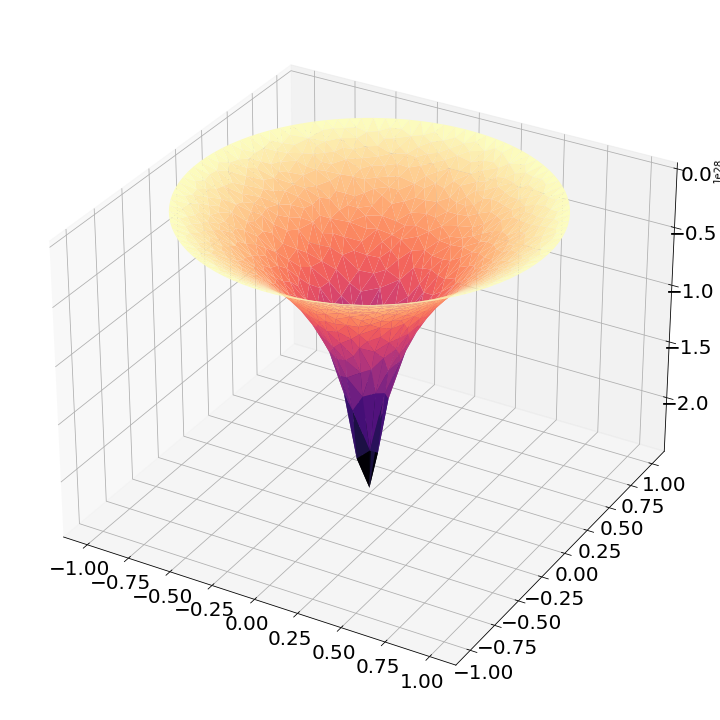

In [13]:
%matplotlib widget
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
ax.zaxis.set_tick_params(labelsize=20)
ax.plot_trisurf(points[:, 0], points[:, 1], c, cmap="magma")
fig.tight_layout()
plt.show()

### Stiffness matrix

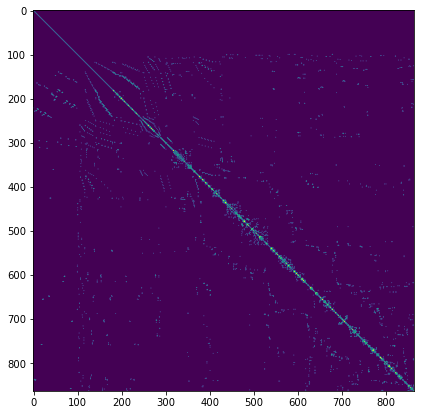

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(matrix != 0)
plt.show()